# Decision Tree

For all four data sets the best node size to stop splitting is reported. The training and test zero-one error for those hyperparameters are reported.

For datasets A and B, also the learned classifier is illustrated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    if len(X) <= num_nodes_stop or len(np.unique(Y)) == 1:
        return DecisionNode(value=np.sign(Y.mean()))
    best_axis, best_threshold = find_best_split(X, Y, criterion)
    if best_axis is None:
        return DecisionNode(value=np.sign(Y.mean()))
    node = DecisionNode(axis=best_axis, threshold=best_threshold)
    X_left, Y_left, X_right, Y_right = split_data(X, Y, best_axis, best_threshold)
    node.left = train_decision_tree(X_left, Y_left, num_nodes_stop, criterion)
    node.right = train_decision_tree(X_right, Y_right, num_nodes_stop, criterion)
    return node

def eval_decision_tree(tree, X):
    predictions = np.zeros(len(X))
    for i in range(len(X)):
        node = tree
        while node.value is None:
            if X[i, node.axis] >= node.threshold:
                node = node.right
            else:
                node = node.left
        predictions[i] = node.value
    return predictions

def calculate_accuracy(Y_true, Y_pred):
    return np.sum(Y_true == Y_pred) / len(Y_true)

def calculate_entropy(Y):
    classes, counts = np.unique(Y, return_counts=True)
    probabilities = counts / len(Y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def split_data(X, Y, axis, split):
    mask = X[:, axis] >= split
    X_right, Y_right = X[mask], Y[mask]
    X_left, Y_left = X[~mask], Y[~mask]
    return X_left, Y_left, X_right, Y_right

def find_best_split(X, Y, criterion):
    best_split_axis, best_split_threshold, best_score = None, None, None
    for axis in range(X.shape[1]):
        thresholds = np.linspace(np.min(X[:, axis]), np.max(X[:, axis]), 10)[1: -1]
        for threshold in thresholds:
            X_left, Y_left, X_right, Y_right = split_data(X, Y, axis, threshold)
            if len(Y_left) == 0 or len(Y_right) == 0:
                continue
            if criterion == 'accuracy':
                score = calculate_accuracy(Y, np.sign(Y_left.mean() - Y_right.mean()))
            elif criterion == 'entropy':
                score = calculate_entropy(Y_left) * len(Y_left) / len(Y) + \
                        calculate_entropy(Y_right) * len(Y_right) / len(Y)
            if best_score is None or score < best_score:
                best_score = score
                best_split_axis, best_split_threshold = axis, threshold
    return best_split_axis, best_split_threshold

class DecisionNode:
    def __init__(self, axis=None, threshold=None, value=None):
        self.axis = axis
        self.threshold = threshold
        self.value = value
        self.left = None
        self.right = None

def validate_decision_tree(X_train, Y_train, X_val, Y_val, num_nodes_stop, criterion):
    tree = train_decision_tree(X_train, Y_train, num_nodes_stop, criterion)
    Y_pred = eval_decision_tree(tree, X_val)
    accuracy = calculate_accuracy(Y_val, Y_pred)
    return accuracy

In [3]:
Datasets = ['A', 'B', 'C', 'D']
num_nodes = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for data in Datasets:
    print("Validation for Dataset_" + data + " using Accuracy")
    dataset = np.load("Data/dataset_" + data + ".npz")
    X_train, Y_train, X_test, Y_test = dataset['arr_0'], dataset['arr_1'], dataset['arr_2'], dataset['arr_3']
    X_train_validation, Y_train_validation = X_train[int(0.6 * len(X_train)):], Y_train[int(0.6 * len(X_train)):]
    X_train, Y_train = X_train[:int(0.6 * len(X_train))], Y_train[:int(0.6 * len(X_train))]
    for i in range(X_train.shape[1]):
        X_test[:, i] = (X_test[:, i] - np.mean(X_train[:, i])) / (np.std(X_train[:, i]) + 1e-5)
        X_train[:, i] = (X_train[:, i] - np.mean(X_train[:, i])) / (np.std(X_train[:, i]) + 1e-5)
    p = np.random.permutation(len(X_train))
    X_train, Y_train = X_train[p], Y_train[p]

    best_accuracy = 0
    best_num_nodes_stop = 0
    for num_nodes_stop in num_nodes:
        accuracy = validate_decision_tree(X_train, Y_train, X_train_validation, Y_train_validation, num_nodes_stop, criterion='accuracy')
        print("Num_stop_nodes =", num_nodes_stop, " Accuracy =", accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_num_nodes_stop = num_nodes_stop

    print("Best num_stop_nodes =", best_num_nodes_stop, " and the corresponding validation accuracy is =", best_accuracy)

    # Training the final model on the entire training set with the best hyperparameters
    final_tree = train_decision_tree(X_train, Y_train, num_nodes_stop=best_num_nodes_stop, criterion='accuracy')
    Y_train_pred = eval_decision_tree(final_tree, X_train)
    Y_test_pred = eval_decision_tree(final_tree, X_test)

    train_accuracy = calculate_accuracy(Y_train, Y_train_pred)
    test_accuracy = calculate_accuracy(Y_test, Y_test_pred)
    print("Train Accuracy =", train_accuracy, " Test Accuracy =", test_accuracy, "\n")

    print("Validation for Dataset_" + data + " using Entropy")
    best_accuracy = 0
    best_num_nodes_stop = 0
    for num_nodes_stop in num_nodes:
        accuracy = validate_decision_tree(X_train, Y_train, X_train_validation, Y_train_validation, num_nodes_stop, criterion='entropy')
        print("Num_stop_nodes =", num_nodes_stop, " Accuracy =", accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_num_nodes_stop = num_nodes_stop

    print("Best num_stop_nodes =", best_num_nodes_stop, " and the corresponding validation accuracy is =", best_accuracy)

    # Training the final model on the entire training set with the best hyperparameters
    final_tree = train_decision_tree(X_train, Y_train, num_nodes_stop=best_num_nodes_stop, criterion='accuracy')
    Y_train_pred = eval_decision_tree(final_tree, X_train)
    Y_test_pred = eval_decision_tree(final_tree, X_test)

    train_accuracy = calculate_accuracy(Y_train, Y_train_pred)
    test_accuracy = calculate_accuracy(Y_test, Y_test_pred)
    print("Train Accuracy =", train_accuracy, " Test Accuracy =", test_accuracy, "\n")

Validation for Dataset_A using Accuracy
Num_stop_nodes = 1  Accuracy = 0.6116666666666667
Num_stop_nodes = 10  Accuracy = 0.6966666666666667
Num_stop_nodes = 20  Accuracy = 0.7366666666666667
Num_stop_nodes = 30  Accuracy = 0.6716666666666666
Num_stop_nodes = 40  Accuracy = 0.6583333333333333
Num_stop_nodes = 50  Accuracy = 0.6733333333333333
Num_stop_nodes = 60  Accuracy = 0.6733333333333333
Num_stop_nodes = 70  Accuracy = 0.7016666666666667
Num_stop_nodes = 80  Accuracy = 0.7033333333333334
Num_stop_nodes = 90  Accuracy = 0.7033333333333334
Num_stop_nodes = 100  Accuracy = 0.7033333333333334
Best num_stop_nodes = 20  and the corresponding validation accuracy is = 0.7366666666666667
Train Accuracy = 0.88  Test Accuracy = 0.874 

Validation for Dataset_A using Entropy
Num_stop_nodes = 1  Accuracy = 0.5483333333333333
Num_stop_nodes = 10  Accuracy = 0.55
Num_stop_nodes = 20  Accuracy = 0.55
Num_stop_nodes = 30  Accuracy = 0.55
Num_stop_nodes = 40  Accuracy = 0.6266666666666667
Num_stop_

**Observations**

When accuracy is the criterion used : 

Dataset | Stopping node choice | Validation Accuracy | Train zero-one error | Test zero-one error
--- |--- |---|--- |---
A | 20 |73.6%| 0.12 | 0.126
B | 60 |69.16%| 0.271 | 0.276
C | 1 |53.83%| 0 | 0.38
D | 1 |31.25%| 0 | 0.213

When entropy is the criterion used : 

Dataset | Stopping node choice | Validation Accuracy| Train zero-one error | Test zero-one error
--- |---|--- |--- |---
A | 80| 63.6% |0.17 | 0.172
B | 60 |80%| 0.271 | 0.276
C | 90|70.6%|0.355 | 0.404
D | 1 |31.25% | 0 | 0.213



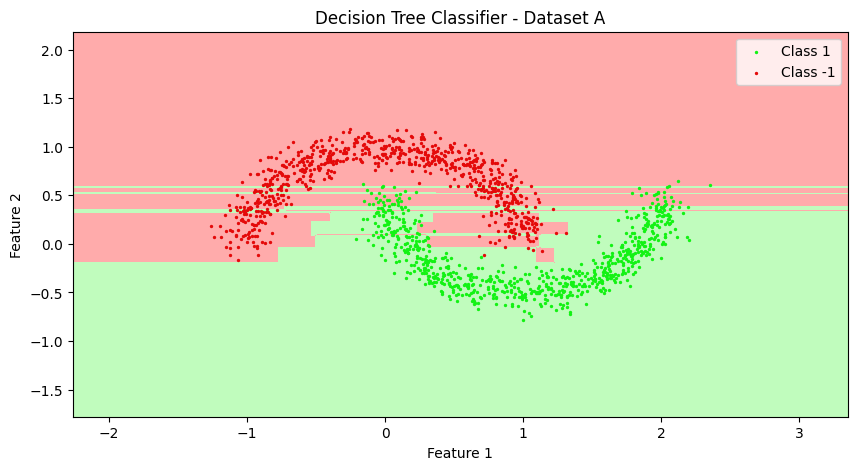

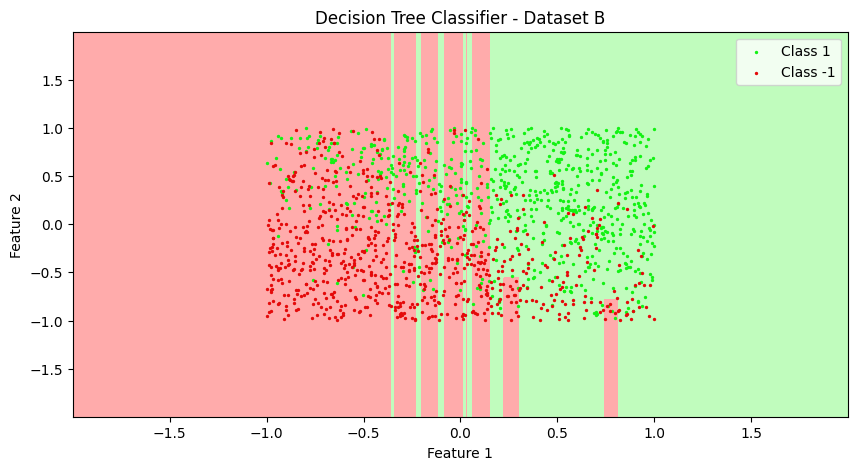

In [4]:
# Define hyperparameters
num_nodes_stop_A = 20
num_nodes_stop_B = 60

dataset_A = np.load("Data/dataset_A.npz")
dataset_B = np.load("Data/dataset_B.npz")

X_A, Y_A = dataset_A['arr_0'], dataset_A['arr_1']

X_B, Y_B = dataset_B['arr_0'], dataset_B['arr_1']

tree_A = train_decision_tree(X_A, Y_A, num_nodes_stop_A)

# Generate decision boundary for dataset A
x_A_min, x_A_max = np.min(X_A[:, 0]) - 1, np.max(X_A[:, 0]) + 1
y_A_min, y_A_max = np.min(X_A[:, 1]) - 1, np.max(X_A[:, 1]) + 1
x_A, y_A = np.meshgrid(np.linspace(x_A_min, x_A_max, 400), np.linspace(y_A_min, y_A_max, 400))
xy_A = np.c_[x_A.ravel(), y_A.ravel()]
Z_A = eval_decision_tree(tree_A, xy_A).reshape(x_A.shape)

# Plot dataset A
plt.figure(figsize=(10, 5))
plt.contourf(x_A, y_A, Z_A, colors=['#ffabab','#c0fcbd'])
plt.scatter(X_A[Y_A==1][:,0],X_A[Y_A==1][:,1],s=2,c='#13f214', label='Class 1')
plt.scatter(X_A[Y_A==-1][:,0],X_A[Y_A==-1][:,1],s=2,c='#e40a0a', label="Class -1")
plt.title("Decision Tree Classifier - Dataset A")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

tree_B = train_decision_tree(X_B, Y_B, num_nodes_stop_B)

# Generate decision boundary for dataset B
x_B_min, x_B_max = np.min(X_B[:, 0]) - 1, np.max(X_B[:, 0]) + 1
y_B_min, y_B_max = np.min(X_B[:, 1]) - 1, np.max(X_B[:, 1]) + 1
x_B, y_B = np.meshgrid(np.linspace(x_B_min, x_B_max, 400), np.linspace(y_B_min, y_B_max, 400))
xy_B = np.c_[x_B.ravel(), y_B.ravel()]
Z_B = eval_decision_tree(tree_B, xy_B).reshape(x_B.shape)

# Plot dataset B
plt.figure(figsize=(10, 5))
plt.contourf(x_B, y_B, Z_B, colors=['#ffabab','#c0fcbd'])
plt.scatter(X_B[Y_B==1][:,0],X_B[Y_B==1][:,1],s=2,c='#13f214', label='Class 1')
plt.scatter(X_B[Y_B==-1][:,0],X_B[Y_B==-1][:,1],s=2,c='#e40a0a', label="Class -1")
plt.title("Decision Tree Classifier - Dataset B")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

